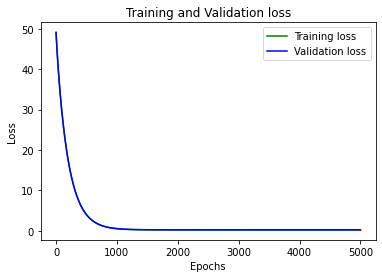

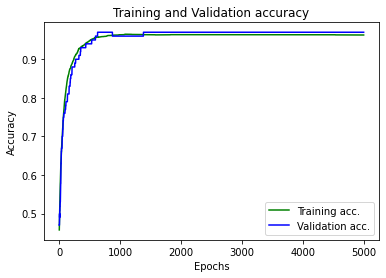

Final train accuracy =  0.9628571428571429
Final validation accuracy =  0.97
Final test accuracy =  0.9655172413793104


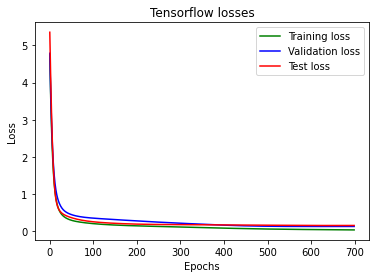

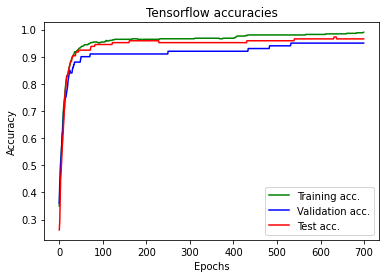

Final train accuracy =  0.99
Final validation accuracy =  0.95
Final test accuracy =  0.9655172413793104
Final train loss =  0.039210703
Final validation loss =  0.13227496
Final test loss =  0.15885288


In [4]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
from random import randrange

def loadData():
    with np.load('notMNIST.npz') as dataset:
        Data, Target = dataset['images'], dataset['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(421)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        train_data, train_target = Data[:3500], Target[:3500]
        valid_data, valid_target = Data[3500:3600], Target[3500:3600]
        test_data, test_target = Data[3600:], Target[3600:]
    return train_data, valid_data, test_data, train_target, valid_target, test_target

# To avoid repetition, defined a y hat calculation function here
def y_hat_calculation(x, W, b):
    return (1 / (1 + np.exp( -(np.matmul(x,W) + b) )))

def loss(W, b, x, y, reg):
    y_hat = y_hat_calculation(x, W, b)
    loss = (np.sum ( -(y * np.log(y_hat)) - \
        (1 - y) * np.log(1 - y_hat))) / (np.shape(y)[0]) \
        + ((reg/2) * np.matmul(np.transpose(W), W))
    return loss[0][0]

def grad_loss(W, b, x, y, reg):
    y_hat = y_hat_calculation(x, W, b)
    # Included derivations in the report
    grad_loss_w = np.matmul(np.transpose(x), (y_hat - y)) \
        / np.shape(y)[0] + reg*W
    # Essentially same as the weight gradient, but now instead
    # of wTx, we have b so the x in the expression is removed
    grad_loss_b = np.sum((y_hat - y))/(np.shape(y)[0])
    return grad_loss_w, grad_loss_b

def grad_descent(W, b, x, y, alpha, epochs, reg, error_tol, \
    valid_data, valid_target, test_data, test_target):

    train_loss = [loss(W, b, x, y, reg)]
    valid_loss = [loss(W, b, valid_data, valid_target, reg)]
    test_loss = [loss(W, b, test_data, test_target, reg)]

    pred_valid = np.matmul(valid_data,W) + b
    valid_accur = [np.sum((pred_valid>=0.5)==valid_target)/(valid_target.shape[0])]
    pred_test = np.matmul(test_data,W) + b
    test_accur = [np.sum((pred_test>=0.5)==test_target)/(test_data.shape[0])]
    pred_train = np.matmul(x,W) + b
    train_accur = [np.sum((pred_train>=0.5)==y)/(x.shape[0])]

    # Logistic regression algorithm from textbook page 95
    for i in range(epochs):
        gradient_w, gradient_b = grad_loss(W, b, x, y, reg)
        diff_w = -alpha * gradient_w
        diff_b = -alpha * gradient_b
        W += diff_w
        b += diff_b
        if np.linalg.norm(diff_w) <= error_tol:
            break
        # Calculate the losses and accuracies
        valid_loss.append(loss(W, b, valid_data, valid_target, reg))
        test_loss.append(loss(W, b, test_data, test_target, reg))
        train_loss.append(loss(W, b, x, y, reg))
        pred_valid = np.matmul(valid_data,W)+b
        valid_accur.append(np.sum((pred_valid>=0.5)==valid_target)/(valid_target.shape[0]))
        pred_test = np.matmul(test_data,W)+b
        test_accur.append(np.sum((pred_test>=0.5)==test_target)/(test_data.shape[0]))
        pred_train = np.matmul(x,W)+b
        train_accur.append(np.sum((pred_train>=0.5)==y)/(x.shape[0]))

    return W, b, valid_accur, test_accur, train_accur, valid_loss, test_loss, train_loss

def buildGraph(beta1 = None, beta2 = None, epsilon = None):
    W = tf.Variable(tf.random.truncated_normal(shape=(784,1), mean=0.0, \
        stddev=1.0, dtype=tf.dtypes.float32, seed=None, name=None))
    b = tf.Variable(0.0)
    x = tf.placeholder(tf.float32, name='x')
    y = tf.placeholder(tf.float32, name='y')
    reg = tf.placeholder(tf.float32, name='reg')
    prediction = tf.matmul(x,W) + b
    loss = tf.losses.sigmoid_cross_entropy(y, prediction) \
        + ((reg/2) * tf.matmul(W,tf.transpose(W)))
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
    # Uncomment this part to change Adam parameters
    # optimizer = tf.train.AdamOptimizer(learning_rate = 0.001, \
    #   epsilon = epsilon)
    training_op = optimizer.minimize(loss=loss)

    # Follow the same procedure for validation and test data
    val_x = tf.placeholder(tf.float32, name='val_x')
    val_y = tf.placeholder(tf.float32, name='val_y')
    val_prediction = tf.matmul(val_x,W) + b
    val_loss = tf.losses.sigmoid_cross_entropy(val_y, val_prediction) \
        + ((reg/2) * tf.matmul(W,tf.transpose(W)))   
    test_x = tf.placeholder(tf.float32, name='test_x')
    test_y = tf.placeholder(tf.float32, name='test_y')
    test_prediction = tf.matmul(test_x,W) + b
    test_loss = tf.losses.sigmoid_cross_entropy(test_y, test_prediction) \
        + ((reg/2) * tf.matmul(W,tf.transpose(W)))

    return W, b, x, tf.sigmoid(prediction), y, loss, optimizer, \
        training_op, reg, tf.sigmoid(val_prediction), val_loss, val_x, val_y, \
        tf.sigmoid(test_prediction), test_loss, test_x, test_y

def numpy_main():
    # Load the data
    train_data, valid_data, test_data, train_target, valid_target, test_target = loadData()
    # Flatten all here so we do not need to worry later on
    train_data = train_data.reshape(np.shape(train_data)[0], np.shape(train_data)[1]*np.shape(train_data)[2])
    valid_data = valid_data.reshape(np.shape(valid_data)[0], np.shape(valid_data)[1]*np.shape(valid_data)[2]) 
    test_data = test_data.reshape(np.shape(test_data)[0], np.shape(test_data)[1]*np.shape(test_data)[2])

    # You can change the values here to reproduce the plots:
    # Mean and standard deviation
    mu, sigma = 0, 0.5
    W_init = np.random.normal(mu, sigma, (train_data.shape[1],1))
    b_init = 0
    alpha = 0.005
    epochs = 5000
    reg = 0.5
    error_tol = 10**-7

    W, b, val_acc, test_acc, train_acc, val_loss, test_loss, train_loss = \
      grad_descent (W_init, b_init, train_data, train_target, alpha, epochs, reg, error_tol, \
    valid_data, valid_target, test_data, test_target)
    epochs_plot = range(epochs + 1)
    plt.plot(epochs_plot, train_loss, 'g', label='Training loss')
    plt.plot(epochs_plot, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.plot(epochs_plot, train_acc, 'g', label='Training acc.')
    plt.plot(epochs_plot, val_acc, 'b', label='Validation acc.')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    print ("Final train accuracy = ", str(train_acc[len(train_acc) - 1]))
    print ("Final validation accuracy = ", str(val_acc[len(val_acc) - 1]))
    print ("Final test accuracy = ", str(test_acc[len(test_acc) - 1]))

def tensorflow_main():
    # Set Adam parameters here
    beta1 = 0
    beta2 = 0
    epsilon = 10**-4
    # Load data
    train_data, valid_data, test_data, train_target, valid_target, test_target = loadData()
    # Flatten all here so we do not need to worry later on
    train_data = train_data.reshape(np.shape(train_data)[0], np.shape(train_data)[1]*np.shape(train_data)[2])
    valid_data = valid_data.reshape(np.shape(valid_data)[0], np.shape(valid_data)[1]*np.shape(valid_data)[2]) 
    test_data = test_data.reshape(np.shape(test_data)[0], np.shape(test_data)[1]*np.shape(test_data)[2])
    W, b, x, prediction, y, loss, optimizer, train, reg,\
      val_prediction, val_loss, val_x, val_y, test_prediction, test_loss, test_x, test_y = \
      buildGraph(beta1, beta2, epsilon)
    # Set the rest of the parameters
    epochs = 700
    batch_size = 500
    reg_val = 0
    batches = np.shape(train_data)[0] / batch_size

    loss_array = []
    val_loss_array = []
    test_loss_array = []
    train_accuracy_array = []
    val_accuracy_array = []
    test_accuracy_array = []
    init_op = tf.global_variables_initializer()
    # Train loop here
    with tf.Session() as sess:
        sess.run(init_op)
        random_indexes = np.random.permutation(len(train_data))
        for step in range(epochs):
            # Shuffle here
            train_data_shuffled = train_data[random_indexes]
            train_target_shuffled = train_target[random_indexes]
            batch_start = 0
            for batch in range(int(batches)):
                train_batch = train_data_shuffled[batch_start:batch_start + batch_size, :]
                target_batch = train_target_shuffled[batch_start:batch_start + batch_size, :]
                batch_start += batch_size
                feed_dict={x:train_batch, y:target_batch, reg: reg_val, val_x: valid_data, \
                    val_y: valid_target, test_x: test_data, test_y: test_target}  

                _, current_loss, current_prediction, current_weight, current_bias, \
                    cur_val_loss, cur_val_prediction, cur_test_loss, cur_test_prediction = \
                sess.run([train, loss, prediction, W, b, val_loss, val_prediction, \
                    test_loss, test_prediction], feed_dict=feed_dict)

            loss_array.append(current_loss[0][0])
            val_loss_array.append(cur_val_loss[0][0])
            test_loss_array.append(cur_test_loss[0][0])
            train_accuracy_array.append(np.sum((current_prediction>=0.5)==target_batch)/(target_batch.shape[0]))
            val_accuracy_array.append(np.sum((cur_val_prediction>=0.5)==valid_target)/(valid_target.shape[0]))
            test_accuracy_array.append(np.sum((cur_test_prediction>=0.5)==test_target)/(test_data.shape[0]))

        # Plotting
        epochs_plot = range(epochs)
        plt.plot(epochs_plot, loss_array, 'g', label='Training loss')
        plt.plot(epochs_plot, val_loss_array, 'b', label='Validation loss')
        plt.plot(epochs_plot, test_loss_array, 'r', label='Test loss')
        plt.title('Tensorflow losses')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        plt.plot(epochs_plot, train_accuracy_array, 'g', label='Training acc.')
        plt.plot(epochs_plot, val_accuracy_array, 'b', label='Validation acc.')
        plt.plot(epochs_plot, test_accuracy_array, 'r', label='Test acc.')
        plt.title('Tensorflow accuracies')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        print("Final train accuracy = ", str(train_accuracy_array[len(train_accuracy_array) - 1]))
        print("Final validation accuracy = ", str(val_accuracy_array[len(val_accuracy_array) - 1]))
        print("Final test accuracy = ", str(test_accuracy_array[len(test_accuracy_array) - 1]))
        print("Final train loss = ", str(loss_array[len(loss_array) - 1]))
        print("Final validation loss = ", str(val_loss_array[len(val_loss_array) - 1]))
        print("Final test loss = ", str(test_loss_array[len(test_loss_array) - 1]))

if __name__ == "__main__":
    numpy_main()
    tensorflow_main()